# Grover Adaptive Search- Cas particulier

## Grover Exemple

In [91]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from math import pi, sqrt

n = 2                     # nbr de qubits de recherche
marque = '11'             # état marqué 
N = 2**n                  # taille de l'espace de recherche


iterations = int(round((pi/4)*sqrt(N))) # Nombre optimal d'itérations 

# Oracle :
def oracle_for_target_11(n):
    """
    Oracle simple qui applique une phase -1 à l'état |11>.
    Pour d'autres cibles, on ajouterait des X avant/après pour mapper la cible sur |11>.
    """
    qc = QuantumCircuit(n, name="Oracle|11>")
    qc.cz(0, 1)
    return qc

# Diffuseur:
def diffuser(n):
    """
    Opérateur de diffusion: H^n -> X^n -> CZ sur |11> -> X^n -> H^n
    Réalise la réflexion autour de l'état uniforme.
    """
    qc = QuantumCircuit(n, name="Diffuser")
    qc.h(range(n))
    qc.x(range(n))
    qc.cz(0, 1)          
    qc.x(range(n))
    qc.h(range(n))
    return qc


grover = QuantumCircuit(n, n)

# État uniforme
grover.h(range(n))

O = oracle_for_target_11(n)
D = diffuser(n)

for _ in range(iterations):
    grover.append(O.to_gate(), range(n))
    grover.append(D.to_gate(), range(n))

# Mesure
grover.measure(range(n), range(n))

print(grover)

sim = Aer.get_backend("aer_simulator")
compiled = transpile(grover, sim)
result = sim.run(compiled, shots=2000).result()
counts = result.get_counts()

print("\nRésultats de mesure (attendu: pic sur '11'):")
print(counts)


     ┌───┐┌─────────────┐┌───────────┐┌─────────────┐┌───────────┐┌─┐   
q_0: ┤ H ├┤0            ├┤0          ├┤0            ├┤0          ├┤M├───
     ├───┤│  Oracle|11> ││  Diffuser ││  Oracle|11> ││  Diffuser │└╥┘┌─┐
q_1: ┤ H ├┤1            ├┤1          ├┤1            ├┤1          ├─╫─┤M├
     └───┘└─────────────┘└───────────┘└─────────────┘└───────────┘ ║ └╥┘
c: 2/══════════════════════════════════════════════════════════════╩══╩═
                                                                   0  1 

Résultats de mesure (attendu: pic sur '11'):
{'10': 516, '11': 549, '00': 454, '01': 481}


## GAS - Cas particulier

## Implémentaion

### Préparation du problème

In [92]:
import numpy as np
from math import pi, sqrt, ceil, log2
from typing import List, Tuple, Dict
import random

class OptimizationProblem:
    def __init__(self, costs: List[float], capacities: List[int], demand: int):
        self.costs = np.array(costs)
        self.capacities = np.array(capacities)
        self.demand = demand
        self.n_vars = len(costs)
        
    def objective_function(self, solution: np.ndarray) -> float:
        """Fonction objectif à minimiser"""
        return np.dot(self.costs, solution)
    
    def is_feasible(self, solution: np.ndarray) -> bool:
        """Vérifie si la solution est réalisable"""
        # Contrainte de capacité
        if np.any(solution < 0) or np.any(solution > self.capacities):
            return False
        
        # Contrainte d'équilibre offre-demande
        if abs(np.sum(solution) - self.demand) > 1e-10:
            return False
            
        return True

### Portes quantiques de base

Je les ai définies à la main pour interpréter l'action de chacune

In [93]:
class QuantumCircuit:
    def __init__(self, n_qubits: int):
        self.n_qubits = n_qubits
        self.state = np.zeros(2**n_qubits, dtype=complex)
        self.state[0] = 1.0  # état |0⟩⊗n
        
    def apply_hadamard(self, qubit: int):
        """Applique une porte Hadamard sur un qubit"""
        H = np.array([[1, 1], [1, -1]]) / sqrt(2)
        self._apply_single_qubit_gate(H, qubit)
        
    def apply_x(self, qubit: int):
        """Applique une porte X (NOT)"""
        X = np.array([[0, 1], [1, 0]])
        self._apply_single_qubit_gate(X, qubit)
        
    def apply_z(self, qubit: int):
        """Applique une porte Z"""
        Z = np.array([[1, 0], [0, -1]])
        self._apply_single_qubit_gate(Z, qubit)
        
    def apply_cz(self, control: int, target: int):
        """Applique une porte CZ (Controlled-Z)"""
        # Matrice CZ pour 2 qubits
        CZ = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, -1]])
        
        self._apply_two_qubit_gate(CZ, control, target)
        
    def apply_oracle(self, oracle_matrix: np.ndarray):
        """Applique un oracle personnalisé"""
        self.state = oracle_matrix @ self.state
        
    def _apply_single_qubit_gate(self, gate: np.ndarray, qubit: int):
        """Applique une porte à un qubit unique"""
        # Crée la matrice complète pour tous les qubits
        full_gate = np.eye(1)
        for q in range(self.n_qubits):
            if q == qubit:
                full_gate = np.kron(full_gate, gate)
            else:
                full_gate = np.kron(full_gate, np.eye(2))
                
        self.state = full_gate @ self.state
        
    def _apply_two_qubit_gate(self, gate: np.ndarray, control: int, target: int):
        """Applique une porte à deux qubits"""
        # Réorganise les qubits pour que control et target soient les premiers
        perm = [control, target]
        other_qubits = [q for q in range(self.n_qubits) if q not in [control, target]]
        perm.extend(other_qubits)
        
        # Applique la permutation
        state_perm = self.state.reshape([2] * self.n_qubits)
        state_perm = np.transpose(state_perm, perm)
        
        # Applique la porte
        new_shape = [4] + [2] * (self.n_qubits - 2)
        state_flat = state_perm.reshape(-1)
        state_flat = gate @ state_flat.reshape(4, -1)
        state_perm = state_flat.reshape(new_shape)
        
        # Inverse la permutation
        inv_perm = np.argsort(perm)
        state_perm = np.transpose(state_perm, inv_perm)
        
        self.state = state_perm.reshape(-1)
        
    def measure(self) -> int:
        """Mesure le circuit et retourne le résultat"""
        probabilities = np.abs(self.state)**2
        outcome = np.random.choice(len(probabilities), p=probabilities)
        return outcome
    
    def get_probabilities(self) -> np.ndarray:
        """Retourne les probabilités de mesure"""
        return np.abs(self.state)**2

### Oracle pour les solutions réalisables

In [94]:
class FeasibilityOracle:
    def __init__(self, problem: OptimizationProblem, n_qubits: int):
        self.problem = problem
        self.n_qubits = n_qubits
        
    def create_oracle_matrix(self) -> np.ndarray:
        """Crée la matrice oracle qui marque les états réalisables"""
        size = 2**self.n_qubits
        oracle = np.eye(size, dtype=complex)
        
        for state in range(size):
            solution = self._state_to_solution(state)
            if self.problem.is_feasible(solution):
                oracle[state, state] = -1  # Phase flip pour les solutions réalisables
                
        return oracle
    
    def _state_to_solution(self, state: int) -> np.ndarray:
        """Convertit un état quantique en solution du problème"""
        # Convertit l'état en représentation binaire
        binary = format(state, f'0{self.n_qubits}b')
        
        # Pour simplifier, on suppose que chaque variable est encodée sur 1 qubit
        # Dans une implémentation réelle, vous auriez besoin de plus de qubits
        solution = np.array([int(bit) for bit in binary])
        
        # Scale selon les capacités (simplifié)
        scaled_solution = solution * self.problem.capacities / 1.0
        
        return scaled_solution

### Implémentaion du Diffuseur de Grover

In [95]:
class GroverAmplification:
    def __init__(self, n_qubits: int):
        self.n_qubits = n_qubits
        
    def create_diffusion_operator(self) -> np.ndarray:
        """Crée l'opérateur de diffusion de Grover"""
        size = 2**self.n_qubits
        diffusion = np.full((size, size), 2/size, dtype=complex) - np.eye(size, dtype=complex)
        return diffusion
    
    def optimal_iterations(self, num_solutions: int, total_states: int) -> int:
        """Calcule le nombre optimal d'itérations de Grover"""
        if num_solutions == 0:
            return 0
            
        theta = np.arcsin(np.sqrt(num_solutions / total_states))
        iterations = round(pi / (4 * theta) - 0.5)
        return max(1, iterations)

### GAS

In [96]:
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple

In [97]:
class GroverAdaptiveSearch:
    def __init__(self, problem: OptimizationProblem, n_qubits_per_var: int = 3):
        self.problem = problem
        self.n_qubits_per_var = n_qubits_per_var
        self.total_qubits = problem.n_vars * n_qubits_per_var
        
        self.grover = GroverAmplification(self.total_qubits)
        self.oracle = FeasibilityOracle(problem, self.total_qubits)
        
    def _solution_to_state(self, solution: np.ndarray) -> int:
        """Convertit une solution en état quantique"""
        state = 0
        for i, value in enumerate(solution):
            quantized = int(round(value * (2**self.n_qubits_per_var - 1) / 
                                self.problem.capacities[i]))
            state = (state << self.n_qubits_per_var) | quantized
        return state
    
    def _state_to_solution(self, state: int) -> np.ndarray:
        """Convertit un état quantique en solution"""
        solution = np.zeros(self.problem.n_vars)
        mask = (1 << self.n_qubits_per_var) - 1
        
        for i in range(self.problem.n_vars - 1, -1, -1):
            quantized = state & mask
            solution[i] = (quantized * self.problem.capacities[i] / 
                          (2**self.n_qubits_per_var - 1))
            state >>= self.n_qubits_per_var
            
        return solution
    
    def run_grover_iteration(self, current_threshold: float = None) -> Tuple[np.ndarray, float, Dict]:
        """Exécute une itération de Grover pour trouver une meilleure solution + histogramme"""
        # Oracle + diffuseur
        oracle_matrix = self._create_threshold_oracle(current_threshold)
        diffusion_matrix = self.grover.create_diffusion_operator()
        
        # Circuit quantique avec registres classiques
        circuit = QuantumCircuit(self.total_qubits, self.total_qubits)
        circuit.h(range(self.total_qubits))
        
        # Nombre d’itérations
        estimated_solutions = 2**(self.total_qubits // 2)
        iterations = self.grover.optimal_iterations(estimated_solutions, 2**self.total_qubits)
        
        for _ in range(iterations):
            circuit.unitary(oracle_matrix, range(self.total_qubits))
            circuit.unitary(diffusion_matrix, range(self.total_qubits))
        
        # Mesures
        circuit.measure(range(self.total_qubits), range(self.total_qubits))
        
        # Simulation
        backend = Aer.get_backend("qasm_simulator")
        transpiled = transpile(circuit, backend)
        job = backend.run(transpiled, shots=1024)
        result = job.result()
        counts = result.get_counts()
        
        # État le plus probable
        most_likely_state = max(counts, key=counts.get)
        solution = self._state_to_solution(int(most_likely_state, 2))
        cost = self.problem.objective_function(solution)
        
        return solution, cost, counts
    
    def _create_threshold_oracle(self, threshold: float = None) -> np.ndarray:
        """Crée un oracle qui marque les solutions réalisables avec coût inférieur au seuil"""
        size = 2**self.total_qubits
        oracle = np.eye(size, dtype=complex)
        
        for state in range(size):
            solution = self._state_to_solution(state)
            
            if self.problem.is_feasible(solution):
                cost = self.problem.objective_function(solution)
                if threshold is None or cost < threshold:
                    oracle[state, state] = -1  # Phase flip
                    
        return oracle
    
    def solve(self, max_iterations: int = 100) -> Dict:
        """Exécute l'algorithme GAS complet"""
        best_solution = None
        best_cost = float('inf')
        history = []
        final_counts = None
        
        # Phase initiale
        print("Recherche d'une solution initiale réalisable...")
        for _ in range(max_iterations):
            solution, cost, counts = self.run_grover_iteration()
            if self.problem.is_feasible(solution):
                best_solution = solution
                best_cost = cost
                final_counts = counts
                print(f"Solution initiale trouvée: coût = {cost:.2f}")
                break
        
        if best_solution is None:
            raise ValueError("Aucune solution réalisable trouvée")
        
        # Phase adaptive
        print("Début de l'optimisation adaptive...")
        for iteration in range(max_iterations):
            solution, cost, counts = self.run_grover_iteration(best_cost)
            final_counts = counts
            
            if self.problem.is_feasible(solution) and cost < best_cost:
                best_solution = solution
                best_cost = cost
                print(f"Itération {iteration}: nouveau meilleur coût = {cost:.2f}")
            
            history.append({
                'iteration': iteration,
                'best_cost': best_cost,
                'current_cost': cost
            })
            
            if iteration > 10 and abs(history[-1]['best_cost'] - history[-10]['best_cost']) < 1e-6:
                print("Convergence atteinte")
                break
        
        return {
            'solution': best_solution,
            'cost': best_cost,
            'history': history,
            'feasible': self.problem.is_feasible(best_solution),
            'counts': final_counts
        }


### Application

Recherche d'une solution initiale réalisable...
Solution initiale trouvée: coût = 13.33
Début de l'optimisation adaptive...
Itération 0: nouveau meilleur coût = 12.00
Convergence atteinte

Solution optimale trouvée:
Coût total: 12.00
Variables: [4. 0.]
Réalisable: True
Demande satisfaite: 4.0 / 4


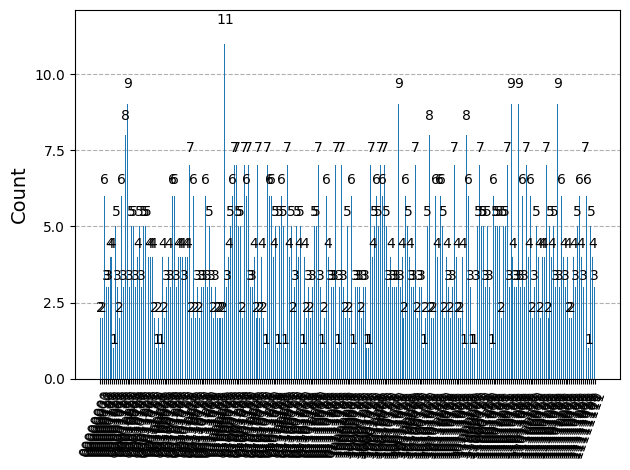


Counts triés (top 10):
01000000 : 11
11010100 : 9
11101100 : 9
10011001 : 9
11011000 : 9
00001110 : 9
10101001 : 8
10111100 : 8
00001101 : 8
10010010 : 7
Clés du résultat : dict_keys(['solution', 'cost', 'history', 'feasible', 'counts'])


In [101]:
%matplotlib inline
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

def main():
    costs = [3, 8]
    capacities = [4, 2]
    total_demand = 4
    
    problem = OptimizationProblem(costs, capacities, total_demand)
    gas = GroverAdaptiveSearch(problem, n_qubits_per_var=4)
    
    result = gas.solve(max_iterations=50)
    
    print("\nSolution optimale trouvée:")
    print(f"Coût total: {result['cost']:.2f}")
    print(f"Variables: {result['solution']}")
    print(f"Réalisable: {result['feasible']}")
    print(f"Demande satisfaite: {np.sum(result['solution']):.1f} / {total_demand}")
    
    if "counts" in result:
        # afficher histogramme
        plot_histogram(result["counts"])
        plt.show()
        
        # afficher liste triée
        sorted_counts = sorted(result["counts"].items(), key=lambda x: x[1], reverse=True)
        print("\nCounts triés (top 10):")
        for bitstring, freq in sorted_counts[:10]:
            print(f"{bitstring} : {freq}")

    return result


result = main()
print("Clés du résultat :", result.keys())
